In [18]:
import random
random.seed(12345678)

In [19]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar

In [20]:
beginrun = datetime.datetime.now()
print ("\nBegin date and time : ", beginrun.strftime("%Y-%m-%d %H:%M:%S"))


Begin date and time :  2025-05-07 11:12:20


In [21]:
outdir="./NM_recom_SOS18/"

In [22]:
total_steps_in_run=100
save_district_graph_mod=10
save_district_plot_mod=10

In [23]:
os.makedirs(outdir, exist_ok=True)
graph = Graph.from_file("NM/NM.shp")


In [24]:
elections = [
    Election("USS18", {"Democratic": "G18USSD", "Republican": "G18USSR"}),
    Election("GOV18", {"Democratic": "G18GOVD", "Republican": "G18GOVR"}),
    Election("SOS18", {"Democratic": "G18SOSD", "Republican": "G18SOSR"}),
    Election("TRE18", {"Democratic": "G18TRED", "Republican": "G18TRER"}),
    Election("ATG18", {"Democratic": "G18ATGD", "Republican": "G18ATGR"}),
    Election("AUD18", {"Democratic": "G18AUDD", "Republican": "G18AUDR"}),
    Election("LND18", {"Democratic": "G18LNDD", "Republican": "G18LNDR"}),
]
sample_node = next(iter(graph.nodes(data=True)))
print(sample_node[1].keys())



dict_keys(['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry'])


In [25]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "HISP": updaters.Tally("HISP", alias="HISP")
}


In [26]:
for _, data in graph.nodes(data=True):
    print(data.keys())
    break

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

dict_keys(['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry'])


In [27]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "SACD", #"2011_PLA_1",     # "GOV", "REMEDIAL_P", 
                                        updaters=my_updaters)

In [28]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [29]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.1,
                   node_repeats=3
                  )

In [30]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [31]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.15)

In [32]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=total_steps_in_run
    )



In [33]:
data = pd.DataFrame(
    sorted(partition["SOS18"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)
num_dist = len(set(initial_partition.assignment.values()))


100%|██████████| 100/100 [00:01<00:00, 56.53it/s]


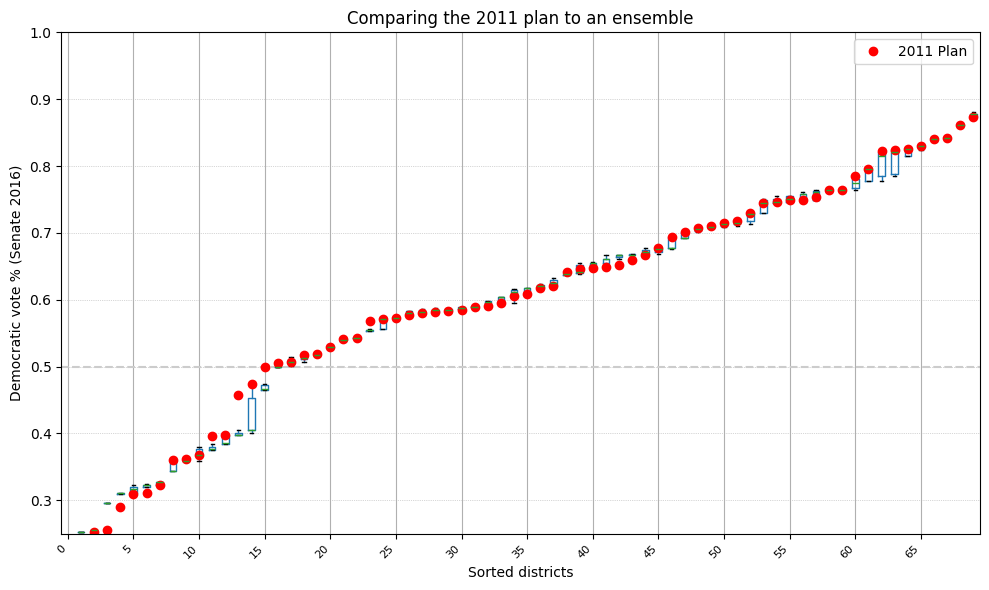

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))  # Slightly wider for clarity

# Draw 50% horizontal line
ax.axhline(0.5, color="#cccccc", linestyle='--')

# Draw boxplot of ensemble
data.boxplot(ax=ax, positions=range(len(data.columns)), showfliers=False)

# Draw red dots for 2011 plan (first row)
ax.plot(data.iloc[0], "ro", label="2011 Plan")

# Beautify X-axis: Show fewer ticks and rotate labels
ax.set_xticks(range(0, len(data.columns), 5))  # Show every 5th district
ax.set_xticklabels(range(0, len(data.columns), 5), rotation=45, ha="right", fontsize=8)

# Titles and labels
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.savefig("PAbox_plotSen2016_SOS18.png")
plt.show()

In [35]:
df=gpd.read_file("NM/NM.shp")

In [36]:
index_output_file = outdir + "_index.csv"

In [37]:
with open(index_output_file, mode='w') as index_file:
    index_writer = csv.writer(index_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    # Run through chain, building outputs
    for t, part in enumerate(chain):
        if t % save_district_graph_mod == 0:
            tmp_str = str(t)
            file_prefix = tmp_str.rjust(8, '0')

            # Add file names to index file
            edges_output_file = outdir + file_prefix + "_edges.csv"
            districts_output_file = outdir + file_prefix + "_districts.csv"
            index_writer.writerow(["./" + file_prefix + "_districts.csv", "./" + file_prefix + "_edges.csv"])
            
            # Build the district graph and write edges to file
            s = set()
            for e in part["cut_edges"]:
                s.add((part.assignment[e[0]], part.assignment[e[1]]))
            
            with open(edges_output_file, mode='w') as edges_file:
                edges_writer = csv.writer(edges_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                for e1 in s:
                    edges_writer.writerow([e1[0], e1[1]])

            # Build the district file that contains election results
            D_votes = part["SOS18"].votes("Democratic")
            R_votes = part["SOS18"].votes("Republican")

            with open(districts_output_file, mode='w') as districts_file:
                districts_writer = csv.writer(districts_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                for i in range(len(D_votes)):
                    districts_writer.writerow([i + 1, int(D_votes[i]), int(R_votes[i]), 0])

            # Save map plot
            if t % save_district_plot_mod == 0:
                df.plot(pd.Series([part.assignment[i] for i in df.index]), cmap="tab20", figsize=(16,8))
                plot_output_file = outdir + file_prefix + "_plot.png"
                plt.savefig(plot_output_file)
                plt.close()

            # Create and save Hispanic % histogram
            num_dist = len(set(part.assignment.values()))
            hisp_percents = []

            for district_id in part["population"]:
                total = part["population"][district_id]
                hisp = part["HISP"][district_id]
                if total > 0:
                    hisp_percents.append(hisp / total)

            # Calculate mean Hispanic percentage across all districts
            mean_hispanic_pct = sum(hisp_percents) / len(hisp_percents)

            plt.figure(figsize=(8, 5))
            plt.hist(hisp_percents, bins=10, edgecolor='black')
            plt.axvline(mean_hispanic_pct, color='red', label=f'Value for Plan: {mean_hispanic_pct:.2f}')
            plt.title(f"Hispanic Population % per District (Step {t})")
            plt.xlabel("Hispanic Population Percentage")
            plt.ylabel("Number of Districts")
            plt.legend()
            hist_output_file = outdir + file_prefix + "_hispanic_hist.png"
            plt.savefig(hist_output_file)
            plt.close()


And if you want to find the total time:

In [38]:
endrun = datetime.datetime.now()
print ("\nEnd date and time : ", endrun.strftime("%Y-%m-%d %H:%M:%S"))

    
diff=endrun-beginrun
print("\nTotal time: ", str(diff))


End date and time :  2025-05-07 11:13:47

Total time:  0:01:26.745839
